Build a regression model.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [59]:
fulldf = pd.read_csv('fulldf.csv')

In [60]:
#drop nulls from rating variables for analysis
fulldf = fulldf[(fulldf['avg_bar_rating'].isnull() == False) & (fulldf['avg_poi_rating'].isnull() == False)]
fulldf.isnull().sum()

name                       0
address                  643
freebikes                  0
slots                      0
latitude                   0
longitude                  0
ll                         0
review_count               0
Bar                        0
Restaurant                 0
POI                        0
avg_bar_rating             0
avg_poi_rating             0
avg_restaurant_rating      0
dtype: int64

In [61]:
#defining variables for all variables model
y = fulldf['freebikes']

X = fulldf.drop(columns = ['freebikes','slots','name','address','ll'])
X = sm.add_constant(X)

In [62]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              freebikes   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     31.48
Date:                Sat, 22 Apr 2023   Prob (F-statistic):           4.95e-50
Time:                        15:48:05   Log-Likelihood:                -3515.1
No. Observations:                1264   AIC:                             7050.
Df Residuals:                    1254   BIC:                             7102.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   364.75

In [63]:
#Backwards stepwise model dropping in order: latitude, avg_bar_rating, avg_restaurant_rating, avg_poi_rating
X = fulldf.drop(columns = ['freebikes','slots','name','address','ll','latitude','avg_bar_rating','avg_restaurant_rating', 'avg_poi_rating'])
X = sm.add_constant(X)

Provide model output and an interpretation of the results. 

In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [65]:
#Run VIF 
vif_data = pd.DataFrame()
vif_data["features"] = X.columns

vif_data["VIF"] = [vif(X.values,i) for i in range(len(X.columns))]
vif_data["Pass"] = vif_data["VIF"]<=10
print(vif_data)

       features           VIF   Pass
0         const  3.115932e+06  False
1     longitude  1.306118e+00   True
2  review_count  5.063886e+00   True
3           Bar  5.866527e+00   True
4    Restaurant  2.956250e+00   True
5           POI  1.177786e+00   True


In [66]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              freebikes   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     56.42
Date:                Sat, 22 Apr 2023   Prob (F-statistic):           5.11e-53
Time:                        15:48:09   Log-Likelihood:                -3516.0
No. Observations:                1264   AIC:                             7044.
Df Residuals:                    1258   BIC:                             7075.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          317.2473    194.439      1.632   

Model is pretty weak with a small rsquare indicating we're missing a lot of explanatory variables OR there's a lot of noise in the data. 

All below interpreted only with all other variables being held equal:
longitude: Each degree of longitude adds about 4 bikes available indicating that the further west you are the less likely you are to find a bike available
review count: Each review for a location had a very small negative impact on bike availability indicating the more well traveled an area (or more reviewed at least) the less likely to find a bike
Bar & POI had a slightly larger impact each on number of bikes. The more locations there were the more likely to find a bike
Restaurants had a smaller impact per restaurant, but there were more restaurants overall so in the same bucket as Bar & POI

Overall, some work to be done to make this a worthwhile model. Next steps would be to grab bike data every 4-5 hours over a two week period and then take an average number of bikes available (or even availability at different times). This model is also built off Chicago data pulled in April and it's quite cold there so not as many people using bikes likely.

Another issue with the model is it's based off only ~100 POIs per location and many locations likely have many more places near them than that. It would probably be possible to sample multiple times from the same API and make a composite, but this would push me over the my monthly requests so I opted not to.

In [67]:
residuals = results.resid
residuals

0       -5.280501
1        4.971295
2        0.206127
3       -5.188728
4        5.886284
          ...    
1347    19.141640
1348    -2.627392
1349     7.400554
1350    -2.107297
1351    -2.164915
Length: 1264, dtype: float64

In [68]:
import scipy

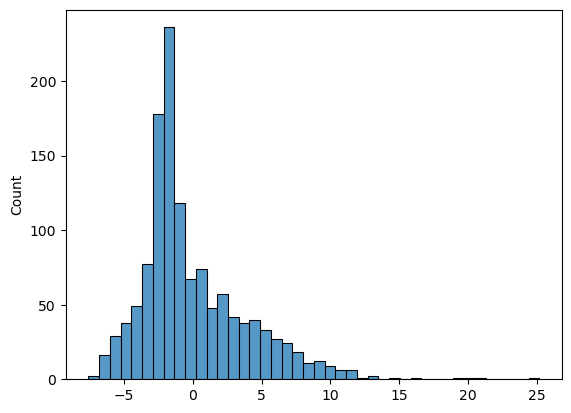

In [69]:
sns.histplot(residuals)
plt.show()

In [70]:
scipy.stats.shapiro(residuals)
#residuals are not normally distributed

ShapiroResult(statistic=0.8990347385406494, pvalue=4.756162479309513e-28)

In [71]:
stat, p, f_stat, f_p = sm.stats.diagnostic.het_breuschpagan(residuals,results.model.exog)
print(p,f_p)
#Model is heteroskedastic 

3.045994913080873e-10 1.935413880039101e-10


In [72]:
#Log transformed number of bikes (adjusting for 0's) in order to hopefully eliminate assumption issues
y = np.log(fulldf['freebikes']+.0001)


X = fulldf.drop(columns = ['freebikes','slots','name','address','ll','latitude','longitude','avg_bar_rating','avg_restaurant_rating', 'avg_poi_rating'])
X = sm.add_constant(X)

In [73]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              freebikes   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     71.73
Date:                Sat, 22 Apr 2023   Prob (F-statistic):           8.78e-55
Time:                        15:48:17   Log-Likelihood:                -3757.0
No. Observations:                1264   AIC:                             7524.
Df Residuals:                    1259   BIC:                             7550.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -7.8286      0.492    -15.908   

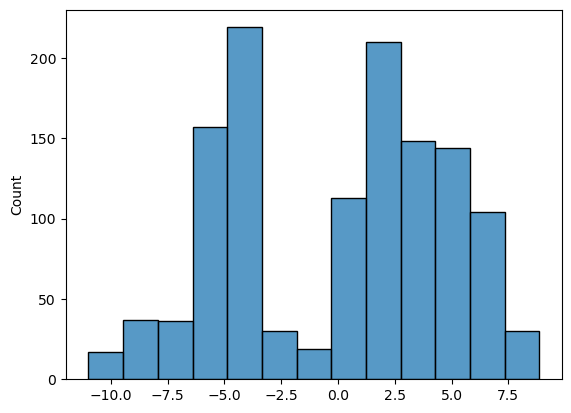

In [74]:
residuals = results.resid
sns.histplot(residuals)
plt.show()

In [75]:
scipy.stats.shapiro(residuals)
#residuals are not normally distributed

ShapiroResult(statistic=0.9396139979362488, pvalue=2.914312697311758e-22)

In [76]:
stat, p, f_stat, f_p = sm.stats.diagnostic.het_breuschpagan(residuals,results.model.exog)
print(p,f_p)

5.938437721080498e-28 1.727056365493783e-29


log transformation performed WORSE on tests, so recommend not using

# Stretch

How can you turn the regression model into a classification model?

To turn this into a classification model we would need to transform the bikes variable into a categorical. So one way to do so would be to convert it to whether there are ANY bikes available or not,
or we could do if there are a certain amount available. Then we'd run a similar analysis but with a logistic regression instead of linear.